# K means clustering algorithm

In this notebook we implement from scratch the popular clustering algorithm K-means. The goal is to take a bunch of points and group them in clusters in such a way that points in clusters are close to each other. The only parameter of the algorithm is the number of clusters K and the result that we want to obtain is a set of K centroids, points that represent the center of the clusters, and data about which point is associated to which centroid. The algorithm is actually very simple. It can be schematically summarized as follows:
1. Randomly initialize the K centroids.
2. Assign each point to the centroid that is closest to it.
3. Update the centroids to the average of the points that are associated to each of them.
4. Repeat 2 and 3 until nothing changes

The idea is simple but implementing it efficiently is harder than it sounds so we will need to be very careful. We could just use loops to go over points and clusters but it is not too efficient so we must introduce matrices. Here is the basic notation that we use:
- num_points (m) = number of points (number of training examples)
- dim (n) = dimension of the space (number of features)
- num_clusters (K) = number of clusters

The ingredients that we use are all arrays of different dimensions:
- data (X) = (m,n) dimensional matrix where each row is one of the points $x^{(i)}$.
- centroids ($\mu$) = (K,n) dimensional matrix whre each row is the position of one of the centroids.
- positions (R) = (K,m) dimensional matrix where each column represents a point and is full of zeros except for a one at the row of its associated cluster.

# Coding the algorithm

In [179]:
import numpy as np

import sklearn
from sklearn.cluster import KMeans

from sklearn.datasets.samples_generator import make_blobs
from time import time
import random

The first step is initializing randomly the centroids. To make sure that the centroids fall on the right region we compute the maximum and the minimum of the data in each direction and generate random numbers in these intervals to make the centroids.

In [180]:
def initialize_centroids(data, num_centroids):
    
    dim = data.shape[1]
    
    mins = np.min(data, axis=0)
    maxs = np.max(data, axis=0)
    mu = np.random.uniform(mins, maxs, size=(num_centroids, dim))
    
    return mu

Now we want to associate each point to a cluster. There is no way to do that step fully using matrices so we iterate over the points. For each point we use python's broadcasting features to compute the distances with centroids and we find for which one it is the smallest. The array 'distances' (for each row in X, or equivalently each point $x^{(i)}$) is built by first making a matrix that contains in each row the vector $x^{(i)}-\mu_k$ (k labels the rows). We then compute the norm of each of these vectors to obtain the $(K,1)$ vector 'distances' and the minimum of these distances tells us where to put the 1 in the column of R associated to the point $i$.

In [181]:
def point_assignment(data, centroids):
    
    num_points = data.shape[0]
    num_centroids = centroids.shape[0]
    positions = np.zeros((num_centroids, num_points))
    
    for i in range(num_points):
        distances = np.linalg.norm(data[i]-centroids, axis=1)
        positions[np.argmin(distances),i] = 1
        
    return positions

This function is the one that updates the centroids according to the mean of the points that are asociated with them. Using the fact that the matrix elements $R_{ki}$ are non zero only when point $i$ is associated to cluster $k$ the mean for a single cluster can be computed using
$$ \mu_k = \frac{\sum_{i=1}^m R_{ki}x^{(i)}}{\sum_{i=1}^m R_{ki}} .$$
The denominator is just the number of points associated to the centroid. It is possible to put this into matrix form to update directly the full matrix $\mu$. The expression for the numerator is simply
$$ \mu = R X $$
where we use the usual matrix multiplication. The denominator is obtained from the matrix $R$ by summing its rows and the division is done using broadcasting. There is one subtlety to take care of since there could be no points associated to a cluster, in which case we divide by zero. To avoid reducing the number of clusters this way we just reposition the centroid to a random position when it happens.

In [182]:
def update_centroids(data, positions, num_centroids):
    
    centroids = np.matmul(positions, data)/(positions.sum(1).reshape(num_centroids,1))
    centroids[centroids==np.inf] = np.nan
    
    random_centroids = initialize_centroids(data, num_centroids)
    
    centroids = np.nan_to_num(centroids) + np.multiply(np.isnan(centroids), random_centroids)
        
    return centroids

It turns out that this algorithm is made to minimize a simple cost function. This cost function is the sum of the distances from each point to its associated cluster. In terms of individual points and centroid the cost can be calculated using
$$ cost = \sum_{k=1}^K\sum_{i=1}^m R_{ki}(x^{(i)}-\mu_k)^2 $$
where the square means the norm of the vector. In terms of matrices we can compute
$$ X - R^T \mu $$
whose rows are points minus their associated centroid. We then just have to take the norm of each row and add the rows, which is the same as taking the Frobenius norm.

In [183]:
def calculate_cost(data, positions, centroids):
    cost = np.linalg.norm(data - np.matmul(positions.T, centroids))
    
    return cost

Putting the positions in matrix form is useful for computations but it is hard to visualize so we make a function to transform it into a $(m,1)$ vector that indicates by a number to which centroid each point belongs.

In [184]:
def convert_positions(positions):
    return np.argmax(positions, axis=0)

Now we can put everything together. We first randomly initialize the centroids. The core of the algorithm is to compute the positions of the points and then update the centroids and these wo steps are repeated until the algorithm finishes. We also compute the cost at every step and use the condition that the cost stays the same to end the computation. We finally convert the last 'positions' matrix to a nice form and give it as the output.

In [185]:
def k_means(data, num_centroids):
    
    centroids = initialize_centroids(data, num_centroids)
    cost = []
    i=0
    
    while True:
        print(i, end='\r')
        positions = point_assignment(data, centroids)
        centroids = update_centroids(data, positions, num_centroids)
        cost.append(calculate_cost(data, positions, centroids))
        print(cost[i], end='\r')
        if i!=0:
            if cost[i]==cost[i-1]:
                break
        i += 1
    
    return convert_positions(positions)

In [186]:
# Generate random Gaussian data to check if everything works fine

data = np.random.randn(50, 5)

In [187]:
# Run the algorithm on the random data and it looks like it gives a reasonable result

k_means(data, 4)

array([3, 1, 3, 2, 2, 2, 1, 1, 3, 2, 0, 2, 2, 2, 2, 3, 3, 3, 0, 2, 0, 3,
       3, 2, 2, 0, 3, 2, 3, 3, 3, 0, 2, 0, 0, 0, 3, 3, 2, 0, 2, 0, 3, 2,
       3, 2, 0, 2, 0, 2], dtype=int64)

# Check against sklearn

Now that we have our home made algorithm we would like to compare with the professional one from sklearn. We first generate data into four blobs with random centers and standard deviations in order to have something to expect.

In [198]:
centers = [(random.randint(0,9), random.randint(0,9)) for i in range(4)]
cluster_std = [random.uniform(0,2) for i in range(4)]

X, y = make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)
y

array([0, 3, 2, 2, 3, 2, 2, 1, 0, 3, 3, 0, 3, 3, 1, 2, 0, 3, 2, 3, 3, 1,
       0, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2, 3, 1, 1, 0, 2, 1,
       2, 0, 1, 0, 0, 1, 3, 2, 3, 0, 3, 1, 2, 0, 1, 1, 3, 3, 2, 2, 3, 1,
       3, 0, 3, 2, 2, 3, 1, 0, 1, 2, 3, 0, 1, 1, 2, 1, 3, 0, 0, 0, 0, 1,
       0, 3, 0, 1, 1, 2, 3, 3, 1, 0, 3, 1])

We then run sklearn's KMeans to predict clusters for this data. We also time to compare the performance.

In [199]:
model = KMeans(n_clusters=4)

t0 = time()
model.fit(X)
t1 = time()
print('Algorithm ran in ', t1-t0, ' seconds')

y_sklearn = model.predict(X)
y_sklearn

Algorithm ran in  0.015633821487426758  seconds


array([1, 1, 2, 2, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2,
       1, 0, 0, 2, 1, 1, 3, 1, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2,
       0, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 0, 0, 1, 2,
       1, 1, 1, 3, 3, 1, 2, 1, 2, 3, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2])

We now run our algorithm for the ame data and predict labels. The run time seems to be pretty similar to the pro one so it is nice!

In [200]:
t0 = time()
y_me = k_means(X, 4)
t1 = time()
print('Algorithm ran in ', t1-t0, ' seconds')
y_me

Algorithm ran in  0.022130250930786133  seconds


array([2, 2, 1, 1, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 2, 0,
       2, 1, 3, 1, 2, 2, 3, 2, 0, 3, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 3, 0,
       3, 2, 1, 2, 2, 1, 2, 3, 2, 2, 2, 0, 3, 2, 1, 0, 2, 2, 1, 3, 2, 1,
       2, 2, 2, 3, 3, 2, 0, 2, 1, 3, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0], dtype=int64)

We now plot the three results next to each other to compare. It looks like our version gives very similar results to the one from sklearn. We have managed to make a good version of k-means clustering! There are however instances where the clusters that we obtain are not the same ones and they vary when we rerun the code so there must be some instability with respect to the random initialization that is not there in the sklearn implementation.

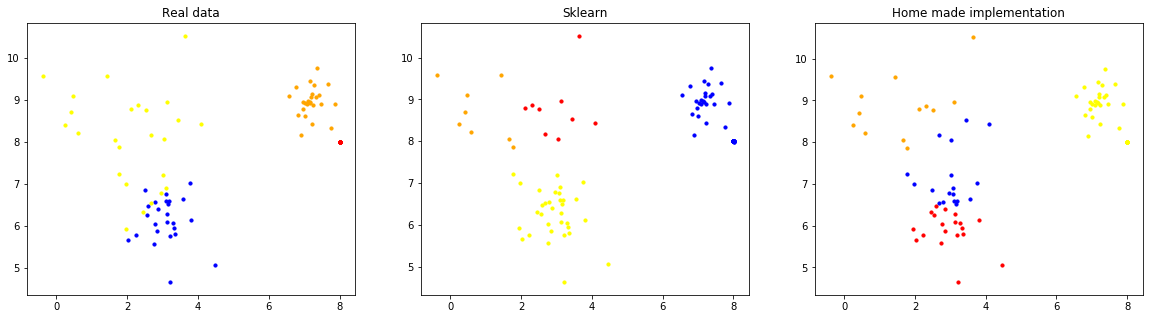

In [201]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

# Plot for real data
ax1.set_title('Real data')
ax1.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
ax1.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
ax1.scatter(X[y == 2, 0], X[y == 2, 1], color="yellow", s=10, label="Cluster3")
ax1.scatter(X[y == 3, 0], X[y == 3, 1], color="orange", s=10, label="Cluster4")

# Plot for clusters in sklearn
ax2.set_title('Sklearn')
ax2.scatter(X[y_sklearn == 0, 0], X[y_sklearn == 0, 1], color="red", s=10, label="Cluster1")
ax2.scatter(X[y_sklearn == 1, 0], X[y_sklearn == 1, 1], color="blue", s=10, label="Cluster2")
ax2.scatter(X[y_sklearn == 2, 0], X[y_sklearn == 2, 1], color="yellow", s=10, label="Cluster3")
ax2.scatter(X[y_sklearn == 3, 0], X[y_sklearn == 3, 1], color="orange", s=10, label="Cluster4")

# Plot for home made algorithm
ax3.set_title('Home made implementation')
ax3.scatter(X[y_me == 0, 0], X[y_me == 0, 1], color="red", s=10, label="Cluster1")
ax3.scatter(X[y_me == 1, 0], X[y_me == 1, 1], color="blue", s=10, label="Cluster2")
ax3.scatter(X[y_me == 2, 0], X[y_me == 2, 1], color="yellow", s=10, label="Cluster3")
ax3.scatter(X[y_me == 3, 0], X[y_me == 3, 1], color="orange", s=10, label="Cluster4")